# 감성분석

In [10]:
# 한글 자연어 처리기 설치
!pip install konlpy

!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 77.4 MB/s eta 0:00:00


In [85]:
import json
import pandas as pd
import numpy as np
import konlpy

import matplotlib.pyplot as plt
import plotly.express as px
import koreanize_matplotlib
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

with open('SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
  SentiWord_info = json.load(f)

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
sentiword = pd.read_json('/content/SentiWord_info.json')
sentiword

,word,word_root,polarity
0,(-;,(,1
1,(;_;),(;_;),-1
2,(^^),(^^),1
3,(^-^),(^-^),1
4,(^^*,(,1
...,...,...,...
14838,반신반의하다,반신반의,0
14839,신비롭다,신비,1
14840,아리송하다,아리송,-1
14841,알쏭하다,알쏭하,-1


In [88]:
youtube_df = pd.read_csv('/content/재난문자 뉴스 댓글 크롤링.csv')
youtube_df

,댓글 내용
0,전쟁휴전 국가에서 심지어 주적이 핵미사일까지 들고있는 상황인데 국민들은 어디로 대피...
1,확실한건 서울에 사는사람이라면 더더욱이 전쟁에 항상 대비하시길 우리나의 대부분은 다...
2,반복되면 안되는 일이지만 이번 오발령으로 인해 부족한점도 알게되었고 혹시라도 있을 ...
3,잘했다. 이렇게 엉망인걸 알게 해줬으니.. 이제 개선을 하겠지?다음에도 또 엉망이면...
4,위급상황 대응이 엉망이란걸 이번에 알게됨. 우왕좌왕……;;;;;;
...,...
455,대피할장소는 초등학생들도배우는데 어른들이 대피장ㅅᆢ도모른다는것은 너무심각한데 무엇때...
456,왜 선제타격은 안 한거냐?
457,대국민 모닝콜! 다음에도 부탁드려요 잇힝
458,7시반에 일어나는데 6시반쯤에 깨워줘서 잠깐 사태파악 안됐다가 1시간 더 잘수있다는...


In [89]:
stopwords = ['문제', '생각', '그냥', '진짜', '지금', '정도', '때문', '이제', '하나', '모든', '것', '뭐']

In [90]:
# 형태소 분석기 설정
okt = konlpy.tag.Okt()

# 댓글 내용에서 명사 추출 및 단어 빈도수 집계
word_df = pd.DataFrame({'word': okt.nouns(' '.join(youtube_df['댓글 내용'].astype(str)))})
word_df = word_df[word_df['word'].str.len() > 1]
word_df = word_df[~word_df['word'].isin(stopwords)]
group_df = word_df.groupby('word', as_index=False).agg(n=('word', 'count')).sort_values('n', ascending=False)
group_df.head(20)

,word,n
256,대피,92
379,문자,79
566,상황,67
948,전쟁,58
714,어디,51
423,발령,50
389,미사일,49
70,경보,47
536,사람,45
126,국민,43


In [91]:
# 감성 점수 계산 함수 (NaN 처리 추가)
def sentiment_score_per_repl(comment):
    repl_score = 0
    try:
        if isinstance(comment, str):  # comment가 문자열인지 확인
            for root, score in zip(sentiword['word_root'], sentiword['polarity']):
                if root in comment:
                    repl_score += score
    except TypeError:  # TypeError 발생 시 pass (무시)
        pass
    return repl_score

# 각 댓글에 대해 감성 점수 계산하여 데이터프레임 생성 (NaN 처리)
youtube_df['댓글 내용'].fillna('', inplace=True)  # NaN 값을 빈 문자열로 대체
df_sentiment = pd.DataFrame({
    '댓글 내용': youtube_df['댓글 내용'],
    '감성점수 총합': youtube_df['댓글 내용'].apply(sentiment_score_per_repl)
})
df_sentiment.reset_index(drop=True, inplace=True)
df_sentiment.head()



,댓글 내용,감성점수 총합
0,전쟁휴전 국가에서 심지어 주적이 핵미사일까지 들고있는 상황인데 국민들은 어디로 대피...,-66
1,확실한건 서울에 사는사람이라면 더더욱이 전쟁에 항상 대비하시길 우리나의 대부분은 다...,-34
2,반복되면 안되는 일이지만 이번 오발령으로 인해 부족한점도 알게되었고 혹시라도 있을 ...,3
3,잘했다. 이렇게 엉망인걸 알게 해줬으니.. 이제 개선을 하겠지?다음에도 또 엉망이면...,-12
4,위급상황 대응이 엉망이란걸 이번에 알게됨. 우왕좌왕……;;;;;;,-6


In [92]:
df_sentiment_twins = df_sentiment.copy()

## 긍정, 부정 댓글 감성점수 총합 계산

In [93]:
# 긍정, 부정 댓글 필터링
df_repl_positive = df_sentiment_twins[df_sentiment_twins['감성점수 총합'] >= 0]
df_repl_negative = df_sentiment_twins[df_sentiment_twins['감성점수 총합'] <= -20]

In [94]:
df_repl_positive.sort_values('감성점수 총합', ascending=False).head(20)

,댓글 내용,감성점수 총합
60,재정비 할수있는 좋은 밑거름이.되길,27
311,우리나라는 휴전상태이기때문에 절대로 살기 좋은 나라 아님 ㅋㅋ,20
45,따뜻한 이불속에서 똑똑히 잘 들었습니다. 감사합니다.,20
122,이런 사태가 오히려 다행이라 생각 합니다. 실제 상황에선 좋은 안내 부탁 드립니다.,19
178,이번 건은 정부가 잘 했다고 봅니다. 우리나라는 전쟁중인 국가입니다. 평화를 당연하...,17
385,"강남역 넘치는 것도 매년 반복인데 몰 하간당? 행정입법사법 빼면, 최고인 대한민국....",16
343,사회주의 민주당 정권이였다면 눈감고 모르른 척 관심도 없었을 것 입니다. 오보가 되...,16
7,관광객 내쫓기 딱 좋네 ㅋ,15
316,주기적으로 민방위훈련합시다차량통제하고 사람들 지하 대피소로 대피하고...옛날처럼 하...,14
81,이번일로 제도개선 확실하게 되기를~~!!,13


In [95]:
df_repl_negative.sort_values('감성점수 총합').head(20)

,댓글 내용,감성점수 총합
171,이게 문제라고 진심으로 생각하시면 당신들은 그냥 어느순간 죽어도 그러려니 하고 받아...,-149
346,이 나라의 국민들이 얼마나 전쟁 위험에 대해 무지하고 어리석은지 다시 한번 깨달았습...,-128
57,잘못보낸것도 문제지만 뭣같은데 그럼 전 국민 대비하도록 전체로 문자를 보내야지 지방...,-125
71,오발령 보다 더 큰 문제가 터졌지. 사이렌 울리고 9분 지나서야 재난문자 옴. 탄도...,-107
21,휴전국가에서 왜 대피하며 어디로 대피해야하는지 안 알려줬다고 욕먹으면 오히려 서울시...,-104
388,"서울 시민으로서 오늘 6:41 분에 받은 문자"" 서울지역에 경계경보 발령 국민 여러...",-102
315,"언론이 국민들을 안심시켜야 하는데, 신났다고 국민들의 불안감을 조성하네.경계경보 발...",-93
361,내가 못알아쳐먹을꺼 같아서 예를 들어서 설명해줄께 아파트 화재경보기 오작동해서 계속...,-90
166,저는 이것도 훈련에일종이라고 생각합니다 ~대피소는 주민분들이 만들어야죠 어디로 대피...,-88
360,대피하시오 문자만 보내놓고 잘못없다거하는 오세훈 시장 ㅡㅡ 차라리 그런 문...,-80


In [96]:
# 형태소 분석기 설정
okt = konlpy.tag.Okt()

# 긍정 댓글 내용에서 명사 추출 및 단어 빈도수 집계 -> 전쟁중이니까 당연히 보내줘야 된다 아니어서 다행이다.
sitive_word_df = pd.DataFrame({'word': okt.nouns(' '.join(df_repl_positive.sort_values('감성점수 총합', ascending=False)['댓글 내용'].astype(str)))})
positive_word_df = positive_word_df.query('word not in @stopwords')
positive_word_df['count'] = positive_word_df['word'].str.len()
positive_group_df = positive_word_df.groupby('word', as_index=False)['count'].count().sort_values(by='count', ascending=False)
positive_group_df.head()

,word,count
40,대피,7
145,이번,6
41,대피소,4
15,공습경보,4
36,다행,3


In [97]:
# 부정 댓글 내용에서 명사 추출 및 단어 빈도수 집계  -> 어디로 대피 해야 할지에 대한 방안 없어서 불안감만 조성
negative_word_df = pd.DataFrame({'word': okt.nouns(' '.join(df_repl_negative.sort_values('감성점수 총합')['댓글 내용'].astype(str)))})
negative_word_df = negative_word_df.query('word not in @stopwords')
negative_word_df['count'] = negative_word_df['word'].str.len()
negative_group_df = negative_word_df.groupby('word', as_index=False)['count'].count().sort_values(by='count', ascending=False)
negative_group_df.head()

,word,count
238,대피,73
359,문자,52
662,어디,46
531,상황,46
370,미사일,44


In [105]:
# 워드 클라우드 생성
def generate_wordcloud(text, title):
    font_path = '/content/BMDOHYEON_ttf.ttf'
    wordcloud = WordCloud(font_path=font_path, background_color='white').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [99]:
df_repl_positive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 2 to 454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   댓글 내용    53 non-null     object
 1   감성점수 총합  53 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


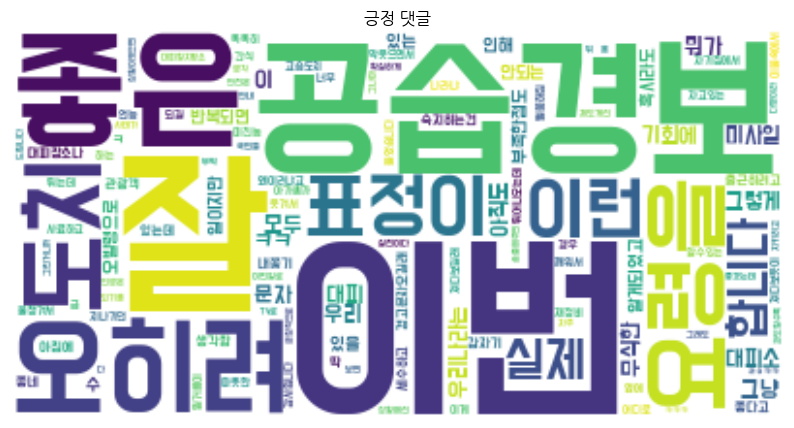

In [100]:
# 긍정 댓글 워드 클라우드 시각화
positive_text = ' '.join(df_repl_positive['댓글 내용'])
generate_wordcloud(positive_text, '긍정 댓글')

In [101]:
df_repl_negative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 455
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   댓글 내용    198 non-null    object
 1   감성점수 총합  198 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


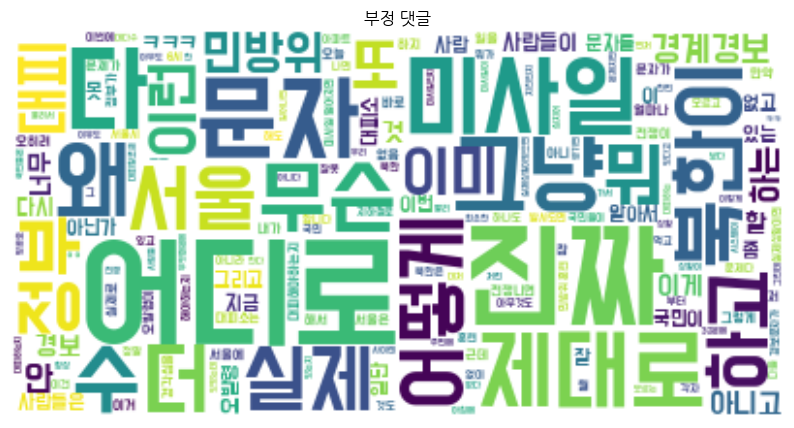

In [102]:
# 부정 댓글 워드 클라우드 시각화
negative_text = ' '.join(df_repl_negative['댓글 내용'])
generate_wordcloud(negative_text, '부정 댓글')

## 마스킹을 활용한 워드클라우드 시각화

In [ ]:
dic_negative_word = negative_group_df.set_index('word').to_dict()['count']
dic_negative_word

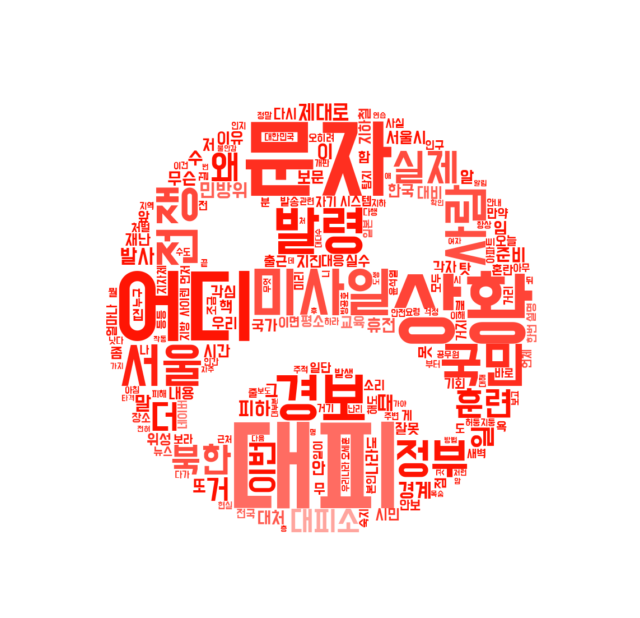

In [111]:
icon = Image.open('/content/bad.png')
negative_mask = np.array(icon)
font_path = '/content/BMDOHYEON_ttf.ttf'

plt.subplots(figsize=(8,8))
wc = WordCloud(width=800, height=700, font_path=font_path, mask = negative_mask, background_color='white').generate_from_frequencies(dic_negative_word)
plt. axis('off')
img_colors = ImageColorGenerator(negative_mask, default_color=(255,255,255))
wc = wc.recolor(color_func=img_colors)
plt.imshow(wc, interpolation='bilinear')
plt.show()